<a href="https://colab.research.google.com/github/Pengchengzhi/Face-Alignment-DRF/blob/main/Fit_Common_Eyes3_Num10_lr0.005.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# function ConnectButton(){
#   console.log("Connect pushed"); 
#   document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click() 
# }
# setInterval(ConnectButton,60000);


# clearInterval(37042)

## 1. Initialize

In [1]:
from google.colab import drive
drive.mount("/content/drive")

import os
path="/content/drive/My Drive/Face Alignment DRF"
os.chdir(path)
os.listdir(path)

Mounted at /content/drive


['__pycache__',
 'utils',
 'datasets',
 'trained_models',
 'checkpoints',
 'Landmarks_Correlation.ipynb',
 'DataPreprocessing_Helen_300W.ipynb',
 'DataPreprocessing_AFW_300W.ipynb',
 'DataPreprocessing_LFPW_300W.ipynb',
 'DataPreprocessing_IBUG_300W.ipynb',
 'DataPreprocessing_Merge_300W.ipynb',
 'Untitled0.ipynb',
 'Final_Datasets',
 'Useless notebooks',
 'Heatmap_each_Cluster_Test_300W.ipynb',
 'DataPreprocessing_COFW.ipynb',
 'Train_on_Common',
 'Train_on_Common2',
 'Heatmap_each_Cluster_Train_300W.ipynb',
 '0000_Converged.ipynb',
 'Fit_Full_Eyes.ipynb',
 'Fit_Common_Eyes.ipynb']

In [2]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os
import cv2
import json
import pandas as pd
from PIL import Image
import torchvision.models as models
import pdb
from torch.nn import Upsample
from torch.autograd import Variable
import torch.optim as optim
import time

import warnings
warnings.filterwarnings('ignore')


In [3]:
from utils.hourglass import *
from utils.dataloader300w import *

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
dim_tree = 5 # how deep the regression tree is 
num_tree = 10 # number of regression trees
variance_gaussian = 3

num_fc = int(num_tree*(2**(dim_tree-1)-1))
num_leaf_nodes = int(num_tree*2**(dim_tree-1))

## 2. Data Loader

In [5]:
w300_commonset = W300_set(dataset_type="common", var=3)
ccommon_dataloder = DataLoader(w300_commonset, batch_size=20, pin_memory=True, shuffle=True, drop_last=True)
rcommon_dataloder = DataLoader(w300_commonset, batch_size=50, pin_memory=True, shuffle=True, drop_last=True)

Loading [1/554] pictures......
Loading [100/554] pictures......
Loading [200/554] pictures......
Loading [300/554] pictures......
Loading [400/554] pictures......
Loading [500/554] pictures......


## 3 Functions

In [6]:
def leaf_direction(N):
  point = torch.zeros(2**N,N).to(device)

  def get01(number, len):
    result = torch.zeros(len).to(device)
    ind = len
    while ind >0:
      if 2**(ind-1)<=number:
        result[len-ind] = 1
        number -= 2**(ind-1)
      ind -= 1
    return result
  
  for i in range(2**N):
    point[i,:] = get01(i,N)

  return point.int()

In [7]:
def split_tree(up,here,which=0,mode='Second'):
  if mode=='initial':
    if which == 0:
      return here
    else: return (1-here)
  else:
    if which == 0:
      return up*here
    else: return up*(1-here)

In [8]:
def split_base(N):
  # returns index that split based on which cnn_fc col
  res = torch.zeros(2**N*N).to(device)
  lenth = 2**(N-1)
  num = 1
  left = 0
  repeat = 1
  max_repeat = 1
  while lenth>0 and repeat<2**N:
    res[left:left+lenth*2] = num
    left += lenth*2
    num += 1
    repeat -= 1
    if repeat == 0:
      lenth = int(lenth/2)
      repeat = max_repeat*2
      max_repeat = repeat
  return ((res.reshape(N,2**N)-1).T).int()

In [9]:
def phi(cnn_fc,mode='train'):
  N = cnn_fc.shape[0]
  out = torch.zeros(N,num_leaf_nodes).to(device)
  sigm = torch.zeros(cnn_fc.shape).to(device)

  if mode == 'test':
    sigm[cnn_fc>0] = 1
  else:
    sigm = torch.sigmoid(cnn_fc)

  direction = leaf_direction(dim_tree-1)
  tree_ind = split_base(dim_tree-1)
  X, Y = tree_ind.shape

  for ind_tree in range(num_tree):
    for x in range(X):
      for y in range(Y):
        here = sigm[:,ind_tree*(X-1)+tree_ind[x,y]]
        if y == 0:
          up = split_tree(torch.rand(3).to(device),here,which=direction[x,y],mode='initial')
        else:
          up = split_tree(up,here,which=direction[x,y])
        #print('y',y,'up',up)

      out[:,ind_tree*X+x] = up
    
  return out

In [10]:
def find_coord(prob_map):
  # prob_map(200,68*256*256)

  N = prob_map.shape[0]
  P = 12
  coord = torch.zeros(N,P*2).to(device)
  heatmap = prob_map.reshape(N,P,256,256).float()
  for n in range(N):
    for p in range(P):
      c1, c2 = torch.where(heatmap[n,p,:,:]==torch.max(heatmap[n,p,:,:]))
      coord[n,2*p], coord[n,2*p+1] = c1[0], c2[0]

  return coord

In [11]:
def get_mask(cnn_heatmaps,threshold=0.3):
  mask = torch.zeros(cnn_heatmaps.shape).to(device)
  B, P = cnn_heatmaps.shape[0:2]
  for b in range(B):
    for p in range(P):
      hm = cnn_heatmaps[b,p,:,:]
      mask[b,p,:,:][hm>torch.max(hm)*threshold]=1
  return mask

In [12]:
def update_iter(q, p, l):
  # q: leaf node
  # p: cnn probability
  # l: label

  gamma = torch.unsqueeze(p,2)*torch.unsqueeze(q,0) # (Ntrain,Nleaf,Nlabel)
  gamma = gamma/(torch.sum(gamma,axis=1,keepdims=True)+1e-8)
  score = torch.zeros(gamma.shape).to(q.device)
  for ll in range(q.shape[0]):
    score[:,ll,:] = l*gamma[:,ll,:]
  score = torch.sum(score,axis=0)+1e-8 # (3,2)

  return score/torch.sum(score,axis=1,keepdims=True)

In [13]:
def loss_ce(B, q, p, l):
  pred = torch.matmul(p,q.reshape(num_leaf_nodes,-1)).reshape(B*12,-1)
  pred = pred/torch.sum(pred,axis=1,keepdims=True)
  l = l.reshape(B*12,-1)
  l = l/torch.sum(l,axis=1,keepdims=True)

  return -criterion_KL(l,pred)

def loss_l1(q, p, l):
  return torch.sum(torch.abs(torch.matmul(p,q)-l))/l.shape[0]

In [14]:
def loss_alogb(B, q, p, l):
  pred = torch.matmul(p,q.reshape(num_leaf_nodes,-1)).reshape(B*12,-1)
  pred = pred/torch.sum(pred,axis=1,keepdims=True)
  l = l.reshape(B*12,-1)
  l = l/torch.sum(l,axis=1,keepdims=True)

  return -torch.sum(l*torch.log(pred))/B

## 4 Network

In [15]:
Tune_HGNet = One_HGNet(nfc=num_fc).to(device)
# Tune_HGNet.load_state_dict(torch.load("/content/drive/My Drive/Face Alignment DRF/trained_models/Original_HGNet.pt"))

## 5 Training

In [16]:
#######################
# Initialization
Total_train = 5

# CNN initilization
nIters = 200
learning_rate = 0.005
optimizer = optim.SGD(Tune_HGNet.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-4)

# Regression Tree parameters
rf_Iters = 60

### Training using Log likelihood

In [ ]:
# update using log likelihood

time_initial = time.time()
for round in range(Total_train):
  time_start = time.time()
  print("############################################################################")
  if torch.cuda.is_available():
    print("Round [%d/%d], Using GPU" %(round+1, Total_train))
  else:
    print("Round [%d/%d]" %(round+1, Total_train))

  
  ######################################################
  ### Train Hourglass
  ### eyes: [36:48]
  ######################################################
  if round == 0:
    leaf_q = torch.ones(num_leaf_nodes,12,256*256).to(device)/(256*256)
    cnn_Iters = 1
  else:
    cnn_Iters = nIters

  for iter in range(cnn_Iters):
    loss_epoch = 0
    for i, (x,_,y) in enumerate(ccommon_dataloder):
      x = x.float().to(device)
      x.requires_grad = True
      y = y.float().to(device)
      B = x.shape[0]

      outputs = Tune_HGNet.forward(x)*(round*0.2+1)
      cnn_prob = phi(outputs)

      cnn_heatmaps = torch.matmul(cnn_prob,leaf_q.reshape(num_leaf_nodes,-1)).reshape(B*12,-1)
      cnn_heatmaps = cnn_heatmaps/torch.sum(cnn_heatmaps,axis=1,keepdims=True)
      label_heatmaps = y[:,36:48,:,:].reshape(B*12,-1)
      label_heatmaps = label_heatmaps/torch.sum(label_heatmaps,axis=1,keepdims=True)
      # loss = -criterion_KL(label_heatmaps,cnn_heatmaps)
      loss = -torch.sum(label_heatmaps*torch.log(cnn_heatmaps+1e-8))/B

      loss_epoch += loss.item()
      if (iter+1)%5 == 0 or iter == 0:
        if i == 9:
          loss_epoch = loss_epoch/10
          print('     CNN training, Iter [%d/%d], loss_CE: %.4f' %(iter+1, cnn_Iters, loss_epoch))

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

  # calculate time for CNN training
  time_cnn = time.time()
  print("     -----> CNN training time: ## %.2f mins ## " %((time_cnn-time_start)/60))

  ######################################################
  ### Train Regression Trees using variational bounding
  ######################################################
  with torch.no_grad():
    loss0, loss_select = 0,0
    leaf_q = leaf_q.reshape(num_leaf_nodes,12,256*256)
    new_leaf_q = torch.zeros(leaf_q.shape).to(device)

    for i, (x,coord,y) in enumerate(rcommon_dataloder):
      next_leaf_q = leaf_q.clone()
      x = x.float().to(device)
      y = y.float().to(device)
      coord = coord.float().to(device)
      B = x.shape[0]
      y_expand = y[:,36:48,:,:].reshape(B,12,-1) #(200,12*256*256)

      outputs = Tune_HGNet.forward(x)*(round*0.2+1)
      cnn_prob = phi(outputs)
      cnn_prob_select = phi(outputs, mode='test')
  
      for rf_iter in range(rf_Iters):
        for points_id in range(12):
          next_leaf_q[:,points_id,:] = update_iter(next_leaf_q[:,points_id,:], cnn_prob, y_expand[:,points_id,:])
        if ((i+1)%4 == 0 or i == 0) and ((rf_iter+1)%10 == 0 or rf_iter == 0):
          # rf_loss_CE = loss_ce(B, next_leaf_q, cnn_prob, y_expand)
          rf_loss_CE = loss_alogb(B, next_leaf_q, cnn_prob, y_expand)
          print("     RF training, Batch %d, rf_iter [%d/%d], loss_CE: %.4f" %(i+1, rf_iter+1, rf_Iters, rf_loss_CE))


      pred_coord0 = find_coord(torch.matmul(cnn_prob,next_leaf_q.reshape(num_leaf_nodes,-1)))
      loss0 += torch.sum(torch.abs(pred_coord0-coord[:,36:48,:].reshape(B,-1)))/B
      pred_coord_select = find_coord(torch.matmul(cnn_prob_select,next_leaf_q.reshape(num_leaf_nodes,-1)))
      loss_select += torch.sum(torch.abs(pred_coord_select-coord[:,36:48,:].reshape(B,-1)))/B

      new_leaf_q += next_leaf_q
    leaf_q = new_leaf_q/torch.sum(new_leaf_q, axis=2, keepdims=True)

    print("     RF training, coordinate loss: %.2f, after selcetion: %.2f" %(loss0/10, loss_select/10))

  # calculate time for rf training
  time_rf = time.time()
  print("     -----> RF training time: ## %.2f mins ## " %((time_rf-time_cnn)/60))
  print("     -----> Training time for this round: ## %.2f mins ## " %((time_rf-time_start)/60))

# calculate total training time
time_end = time.time()
print("-----> Total training time: ## %.2f hrs ## " %((time_end-time_initial)/3600))

############################################################################
Round [1/5], Using GPU
     CNN training, Iter [1/1], loss_CE: 133.0764
     -----> CNN training time: ## 0.37 mins ## 
     RF training, Batch 1, rf_iter [1/60], loss_CE: 92.1550
     RF training, Batch 1, rf_iter [10/60], loss_CE: 90.7758
     RF training, Batch 1, rf_iter [20/60], loss_CE: 90.1115
     RF training, Batch 1, rf_iter [30/60], loss_CE: 89.8395
     RF training, Batch 1, rf_iter [40/60], loss_CE: 89.7072
     RF training, Batch 1, rf_iter [50/60], loss_CE: 89.6339
     RF training, Batch 1, rf_iter [60/60], loss_CE: 89.5892
     RF training, Batch 4, rf_iter [1/60], loss_CE: 93.3444
     RF training, Batch 4, rf_iter [10/60], loss_CE: 91.7666
     RF training, Batch 4, rf_iter [20/60], loss_CE: 91.0890
     RF training, Batch 4, rf_iter [30/60], loss_CE: 90.8176
     RF training, Batch 4, rf_iter [40/60], loss_CE: 90.6893
     RF training, Batch 4, rf_iter [50/60], loss_CE: 90.6195
     RF trai

In [ ]:
outputs.shape

torch.Size([20, 128, 256, 256])

In [ ]:
p = cnn_prob.clone()
p_test = cnn_prob_test.clone()
q = leaf_q.clone()
img = x.clone()
l = y.clone()
c = coord.clone()

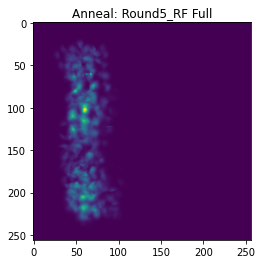

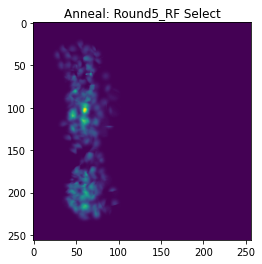

In [ ]:
# plot the face after rf training
# Does not select
rf_heatmaps = torch.matmul(cnn_prob,leaf_q.reshape(num_leaf_nodes,-1)).reshape(B,12,-1)
first_face = torch.sum(rf_heatmaps[0,:,:],axis=0)
first_face = first_face/torch.sum(first_face)
plt.imshow(first_face.reshape(256,256).detach().cpu())
plt.title("Anneal: Round"+str(round+1)+"_RF Full")
# plt.savefig(os.path.join("checkpoints/Anneal_Full_Train/var"+str(variance_gaussian)+"_LossKL_dim"+str(dim_tree)+"_num"+str(num_tree)+"_Round"+str(round+1)+"_RF_Full.png"))
plt.show()

# Select
cnn_prob_test = phi(outputs, mode='test')
rf_heatmaps = torch.matmul(cnn_prob_test,leaf_q.reshape(num_leaf_nodes,-1)).reshape(B,12,-1)
first_face = torch.sum(rf_heatmaps[0,:,:],axis=0)
first_face = first_face/torch.sum(first_face)
plt.imshow(first_face.reshape(256,256).detach().cpu())
plt.title("Anneal: Round"+str(round+1)+"_RF Select")
# plt.savefig(os.path.join("checkpoints/Anneal_Full_Train/var"+str(variance_gaussian)+"_LossKL_dim"+str(dim_tree)+"_num"+str(num_tree)+"_Round"+str(round+1)+"_RF_Select.png"))
plt.show()


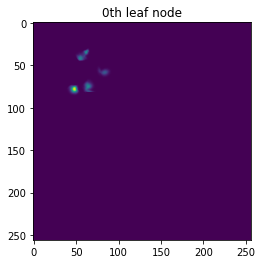

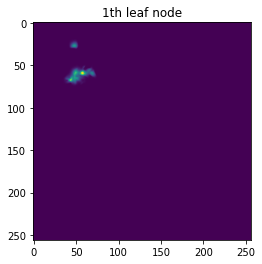

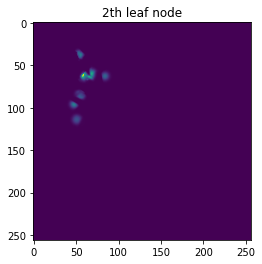

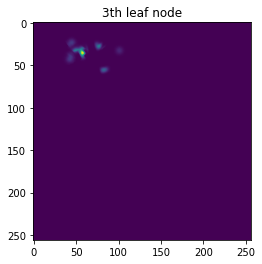

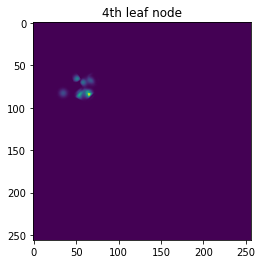

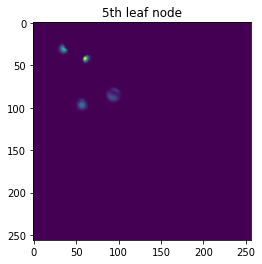

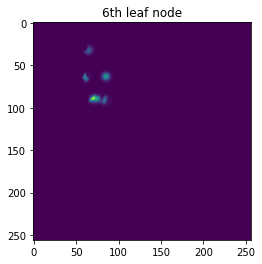

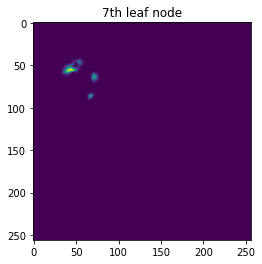

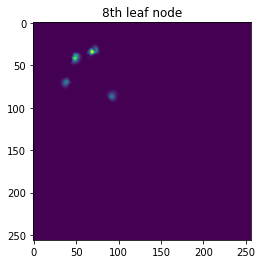

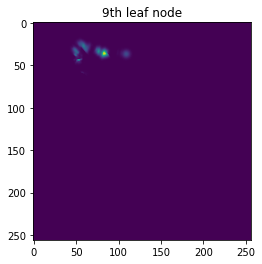

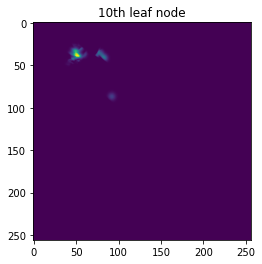

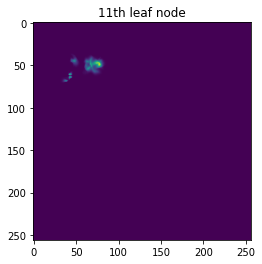

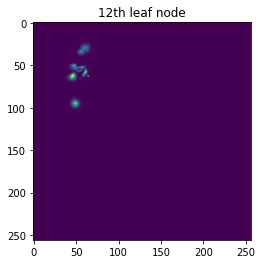

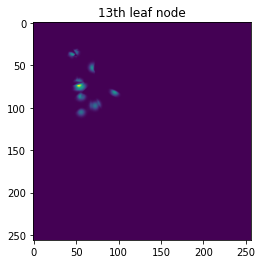

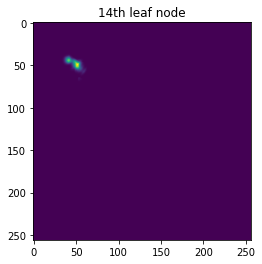

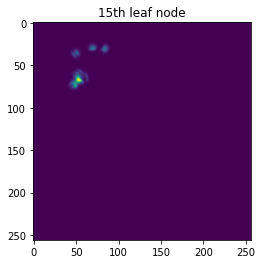

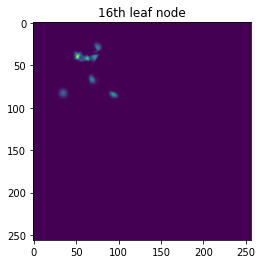

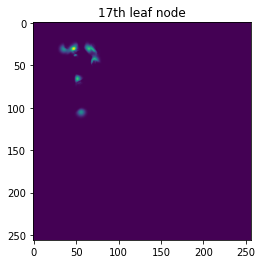

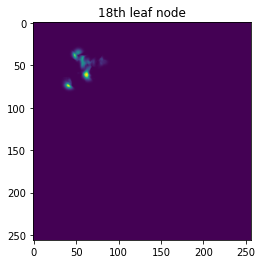

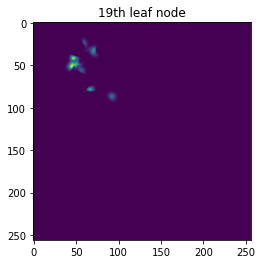

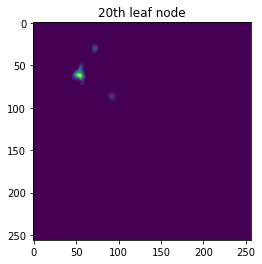

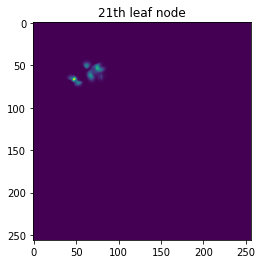

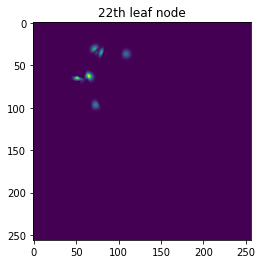

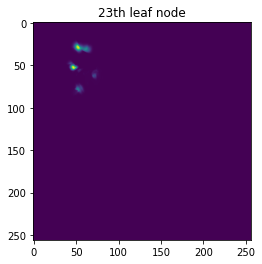

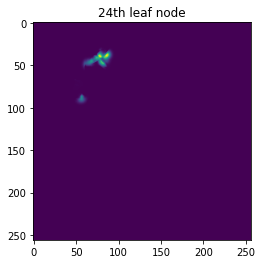

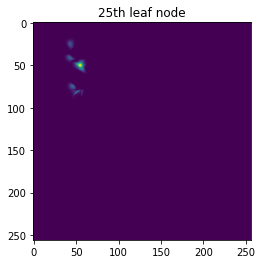

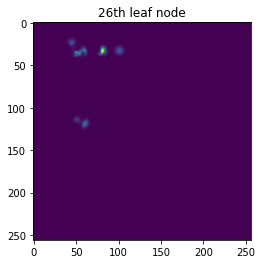

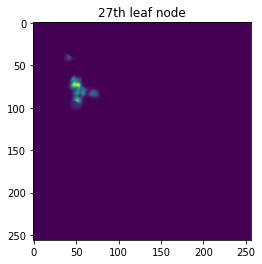

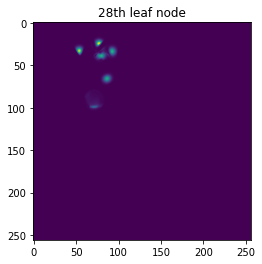

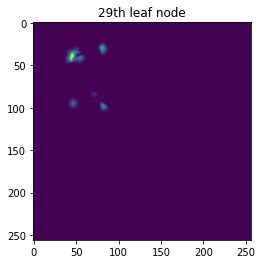

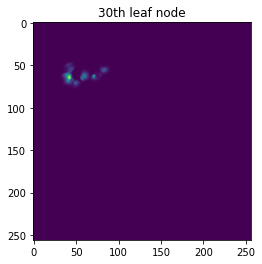

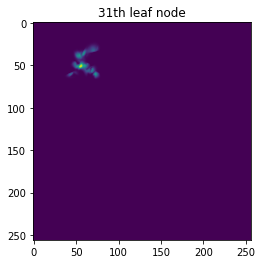

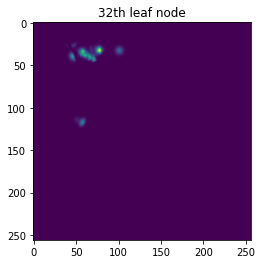

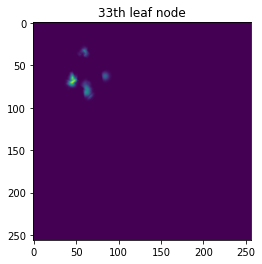

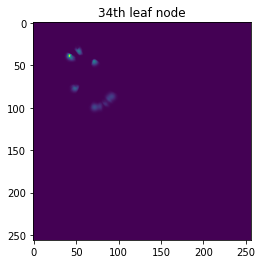

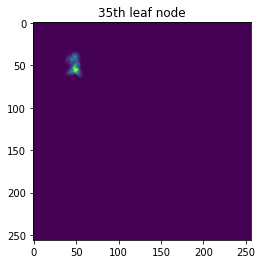

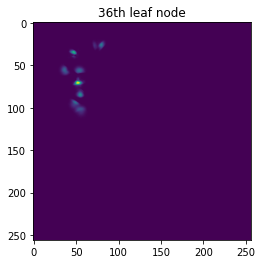

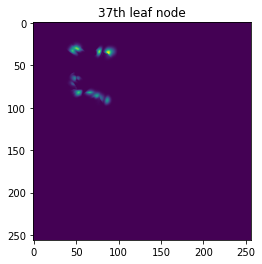

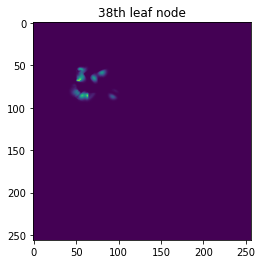

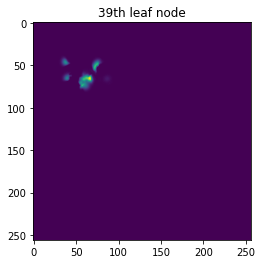

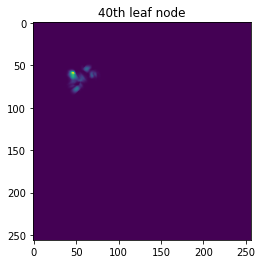

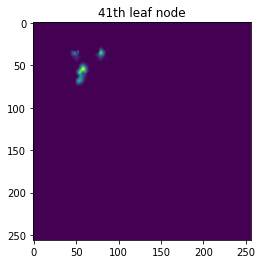

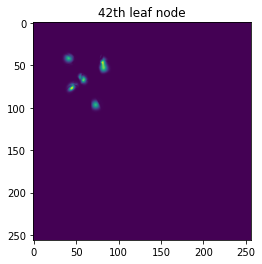

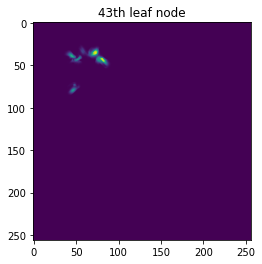

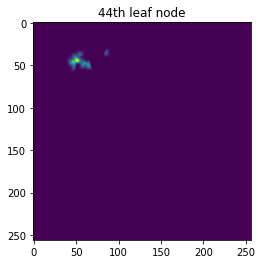

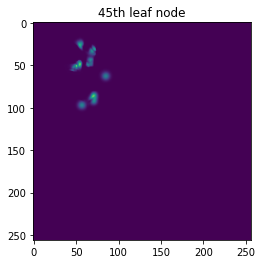

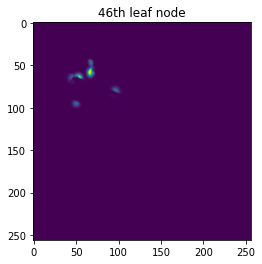

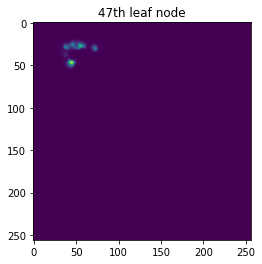

In [ ]:
jth = 0
for jth in range(48):
  plt.imshow(leaf_q[jth,0,:].reshape(256,256).detach().cpu())
  plt.title(str(jth)+"th leaf node")
  plt.show()

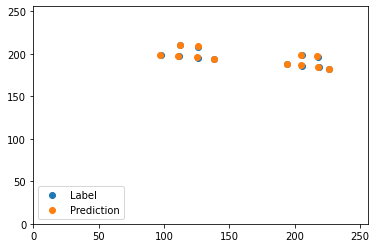

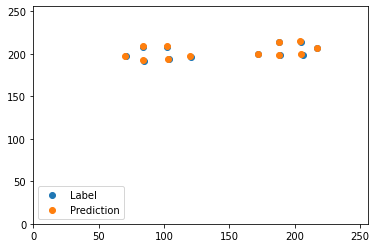

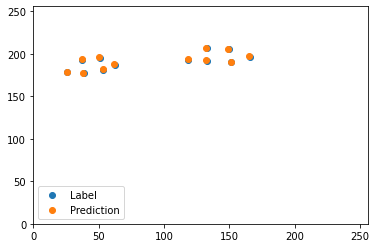

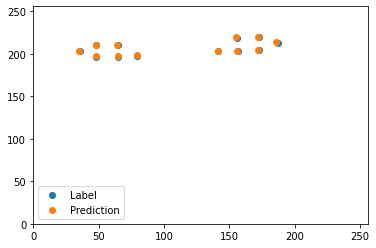

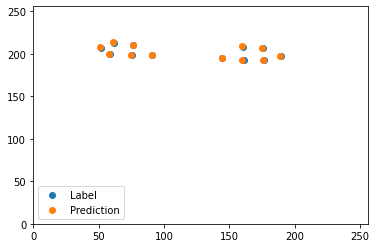

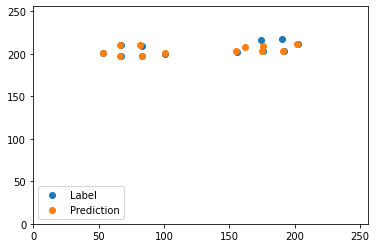

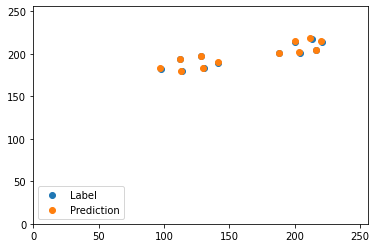

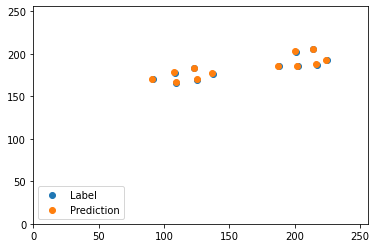

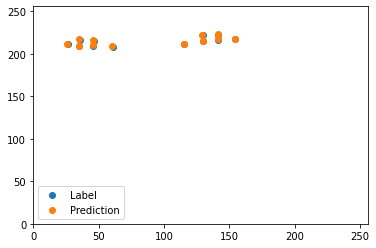

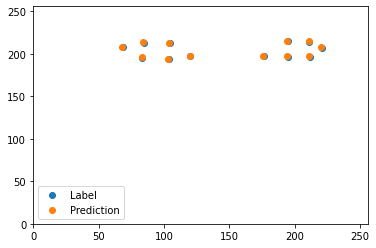

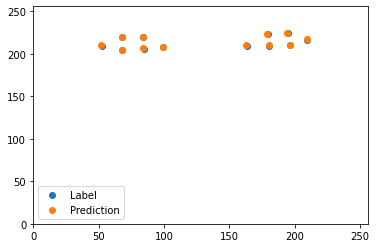

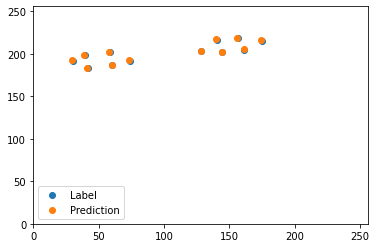

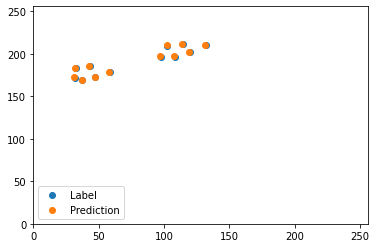

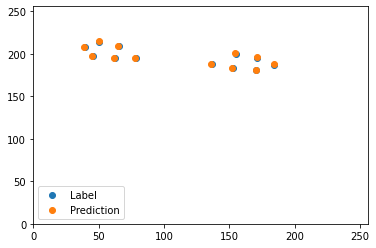

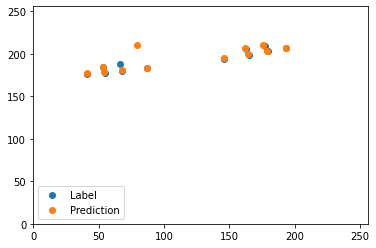

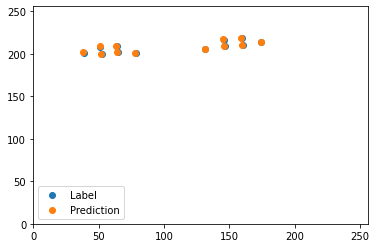

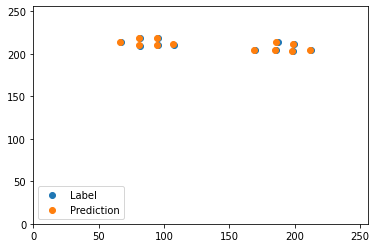

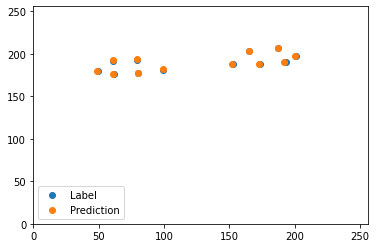

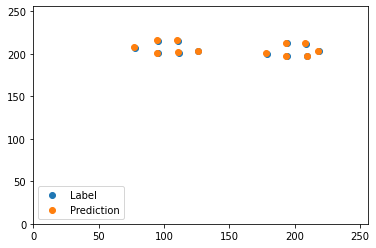

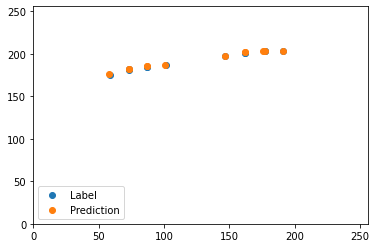

In [ ]:

for ith in range(20):
  px = pred_coord0[ith,::2].detach().cpu()
  py = pred_coord0[ith,1::2].detach().cpu()

  lx = coord[ith,36:48,0].detach().cpu()
  ly = coord[ith,36:48,1].detach().cpu()

  plt.scatter(lx,256-ly,label='Label')
  plt.scatter(px,256-py,label='Prediction')

  plt.xlim(0,256)
  plt.ylim(0,256)
  plt.legend(loc='lower left')
  plt.show()

(0.0, 256.0)

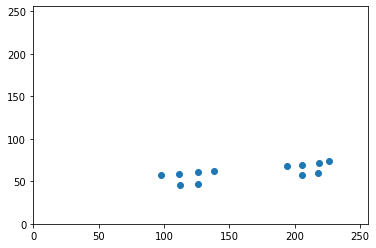

In [ ]:
lx = coord[ith,36:48,0].detach().cpu()
ly = coord[ith,36:48,1].detach().cpu()
plt.scatter(lx,ly,label='Label')
plt.xlim(0,256)
plt.ylim(0,256)

In [ ]:
plt.imshow()